**Import all the necessary libraries**

In [2]:
# !pip install blis
# !pip install spacy
# python -m spacy download en_core_web_sm
# !pip uninstall pandas
# !pip install pandas==1.5 matplotlib==3.6
# !python -m spacy download en_core_web_sm
# !pip install streamlit


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbs
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, log_loss, classification_report, accuracy_score,  roc_auc_score, roc_curve, auc
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import pickle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

**Importing The Data**

In [4]:
df_fake = pd.read_csv("Fake.csv")
df_true = pd.read_csv("True.csv")
df_fake['Label']='Fake'
df_true['Label']='True'
df_fake.shape, df_true.shape

((23481, 5), (21417, 5))

**Observation:**

*Here we observe that nearly all of the true texts contain the word "Reuters". This presence may lead to overfitting during model training. Hence, we will need to remove it during the data preprocessing stage.*

In [5]:
j=0
for i in df_true['text']:
    if '(Reuters)' in i:
        j+=1
j

21247

**Manual Testing Dataset**

In [6]:
df_manual=pd.DataFrame()
df_manual['title']=''
df_manual['text']=''
df_manual['subject']=''
df_manual['date']=''
df_manual['Label']=''


for i in range(516,526):
    df_manual.loc[len(df_manual)]= df_fake.loc[i]
    df_fake.drop(index=i, inplace=True, axis='index')
for i in range(487,498):
    df_manual.loc[len(df_manual)]= df_true.loc[i]
    df_true.drop(index=i, inplace=True, axis='index')
df_fake.shape, df_true.shape

((23471, 5), (21406, 5))

**Combining The Dataset**

In [7]:
df_train= pd.concat([df_fake, df_true], axis=0)
df_train

,title,text,subject,date,Label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",Fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",Fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",Fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",Fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",Fake
...,...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",True
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",True
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",True
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",True


In [8]:
df_train=df_train.sample(frac=0.5)

**Preprocessing Data**

In [9]:
df_train.shape

(22438, 5)

In [10]:
df_train.describe()

,title,text,subject,date,Label
count,22438,22438,22438,22438,22438
unique,20824,20631,8,2349,2
top,Factbox: Trump fills top jobs for his administ...,,politicsNews,"December 20, 2017",Fake
freq,8,323,5641,84,11766


In [11]:
df_train.head(5)

,title,text,subject,date,Label
73,White House aide sees temporary funding fix fo...,WASHINGTON (Reuters) - A short-term fix to fun...,politicsNews,"December 20, 2017",True
7774,Trump Has Quiet Black Students Removed From R...,The latest racial incident associated with the...,News,"February 29, 2016",Fake
20102,"Russia says close to Syria deal with Turkey, Iran","ASTANA (Reuters) - Russia, Turkey and Iran are...",worldnews,"September 14, 2017",True
19595,"At least 10 dead, 92 missing in eastern Congo ...",ABIDJAN (Reuters) - At least 10 people have di...,worldnews,"September 20, 2017",True
8966,Tom Cotton Accepted $1 Million From Israel To...,How much money does it take for a foreign nati...,News,"January 4, 2016",Fake


In [12]:
df_train.fillna('', inplace=True)
df_train.isna().sum()

title      0
text       0
subject    0
date       0
Label      0
dtype: int64

In [13]:
df_train.drop_duplicates(inplace=True)
df_train.duplicated().sum()

0

In [14]:
df_train.reset_index(inplace=True)
df_train

,index,title,text,subject,date,Label
0,73,White House aide sees temporary funding fix fo...,WASHINGTON (Reuters) - A short-term fix to fun...,politicsNews,"December 20, 2017",True
1,7774,Trump Has Quiet Black Students Removed From R...,The latest racial incident associated with the...,News,"February 29, 2016",Fake
2,20102,"Russia says close to Syria deal with Turkey, Iran","ASTANA (Reuters) - Russia, Turkey and Iran are...",worldnews,"September 14, 2017",True
3,19595,"At least 10 dead, 92 missing in eastern Congo ...",ABIDJAN (Reuters) - At least 10 people have di...,worldnews,"September 20, 2017",True
4,8966,Tom Cotton Accepted $1 Million From Israel To...,How much money does it take for a foreign nati...,News,"January 4, 2016",Fake
...,...,...,...,...,...,...
22389,17902,EU again urges dialogue to end Catalan crisis,BRUSSELS (Reuters) - The European Commission r...,worldnews,"October 10, 2017",True
22390,12048,Philippines says Maoist rebels attacked soldie...,MANILA (Reuters) - Maoist rebels attacked sold...,worldnews,"December 18, 2017",True
22391,16271,U.S. wants Pakistan to act quickly to show sup...,WASHINGTON (Reuters) - The United States wants...,worldnews,"October 27, 2017",True
22392,4954,Trump’s Newest Foreign Policy Advisor Is One ...,If you weren t having nightmares before about ...,News,"August 21, 2016",Fake


**Code to Remove the word "Reuter"**

In [15]:
def reuters_removal(text):
    reuters_text=''
    reuters_text= text.split()
    reuters_text= [word for word in reuters_text if not word=="(Reuters)"]
    reuters_text= [word for word in reuters_text if not word=="Reuters"]
    reuters_text= " ".join(reuters_text)
    return reuters_text
df_train['text']=df_train['text'].apply(reuters_removal)

In [16]:
j=0
for i in df_train.loc[df_train['Label']=="True", 'text']:
    if '(Reuters)' in i:
        j+=1

j

5

**Data Visualization**

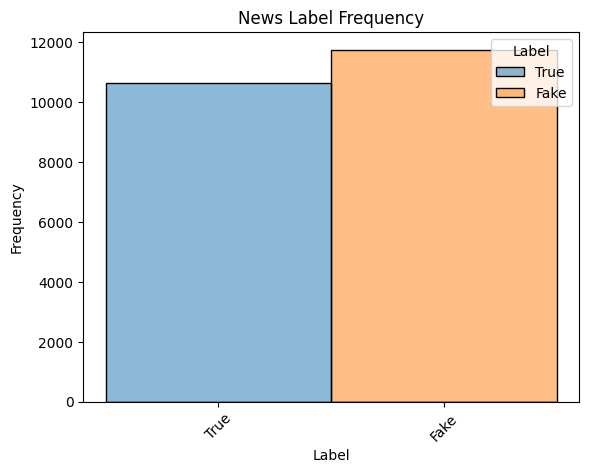

In [17]:
sbs.histplot(x='Label', hue='Label',data=df_train)
plt.title('News Label Frequency')
plt.xticks(rotation=45)
plt.ylabel('Frequency');

In [18]:
df_top=df_train.copy()
df_top_group=df_top.subject.value_counts()
df_top_group

politicsNews       5628
worldnews          5002
News               4536
politics           3432
left-news          2242
Government News     790
US_News             393
Middle-east         371
Name: subject, dtype: int64

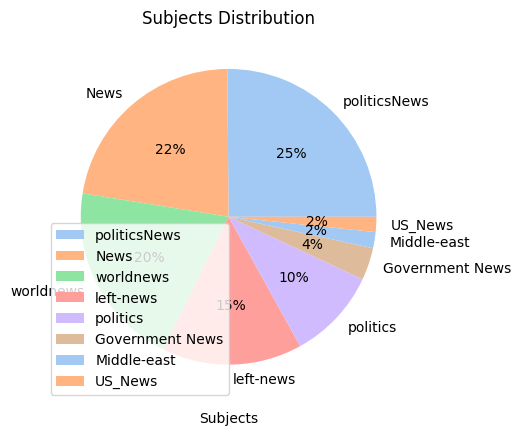

In [19]:
colors = sbs.color_palette('pastel')[0:6]
plt.pie(df_top_group,labels=df_top.subject.unique(),autopct='%.0f%%', colors=colors)
plt.title('Subjects Distribution')
plt.xlabel('Subjects')
plt.legend(df_top.subject.unique(), loc='lower left')
plt.show();

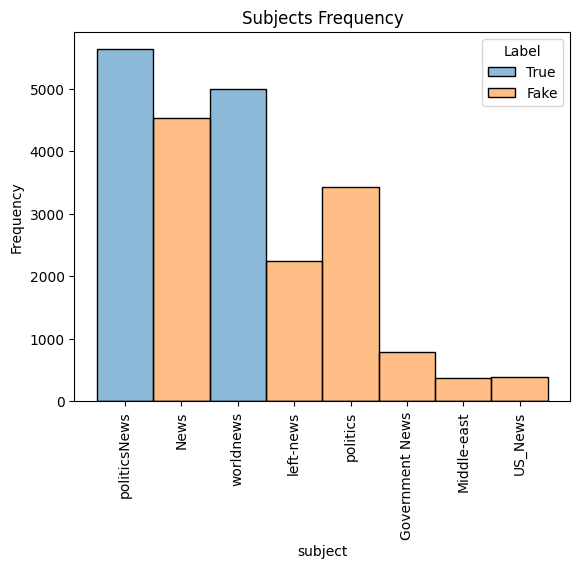

In [20]:
top_parties = df_train['subject'].value_counts().nlargest(5).index
df_top=df_train.copy()
df_top.loc[~df_top['subject'].isin(top_parties), 'Party'] = 'Other'
sbs.histplot(x='subject', hue='Label', data=df_top, stat='count')
plt.title('Subjects Frequency')
plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.show();

In [21]:
df_train.loc[df_train['subject']=="politicsNews","Label"].unique()

array(['True'], dtype=object)

**Splitting The Data**

*We will split the dataset into training and testing sets. Additionally, we will encode the labels into numerical values to facilitate the calculation of the reliability percentage of the news articles.*

In [22]:
y= df_train['Label']
X=df_train.drop(['Label', "date",'index'], axis=1)
y.unique()

array(['True', 'Fake'], dtype=object)

In [23]:
X

,title,text,subject
0,White House aide sees temporary funding fix fo...,WASHINGTON - A short-term fix to fund the Chil...,politicsNews
1,Trump Has Quiet Black Students Removed From R...,The latest racial incident associated with the...,News
2,"Russia says close to Syria deal with Turkey, Iran","ASTANA - Russia, Turkey and Iran are close to ...",worldnews
3,"At least 10 dead, 92 missing in eastern Congo ...",ABIDJAN - At least 10 people have died and ano...,worldnews
4,Tom Cotton Accepted $1 Million From Israel To...,How much money does it take for a foreign nati...,News
...,...,...,...
22389,EU again urges dialogue to end Catalan crisis,BRUSSELS - The European Commission repeated it...,worldnews
22390,Philippines says Maoist rebels attacked soldie...,MANILA - Maoist rebels attacked soldiers deliv...,worldnews
22391,U.S. wants Pakistan to act quickly to show sup...,WASHINGTON - The United States wants Pakistan ...,worldnews
22392,Trump’s Newest Foreign Policy Advisor Is One ...,If you weren t having nightmares before about ...,News


**Stemming and Stop Words**

In [24]:
port_stemmer= PorterStemmer()
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def stemmer(text):
    # Process the text
    doc = nlp(text)

    # Extract the lemma of each token if it is not a stopword or punctuation
    return ' '.join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])
X['text']= X['text'].apply(stemmer)
X=X['text']
X

0        WASHINGTON short term fix fund Children Health...
1        late racial incident associate Donald Trump Pr...
2        ASTANA Russia Turkey Iran close finalize agree...
3        abidjan 10 people die 92 miss eastern Democrat...
4        money foreign nation buy United States Senator...
                               ...                        
22389    BRUSSELS European Commission repeat dialogue S...
22390    manila Maoist rebel attack soldier deliver rel...
22391    WASHINGTON United States want Pakistan quickly...
22392    weren t have nightmare Donald Trump potentiall...
22393    SACRAMENTO powerful politician California adva...
Name: text, Length: 22394, dtype: object

**Train Test Split**

In [26]:
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=40, stratify=y)

**TF-IDF Vectorization**

*TF-IDF (Term Frequency-Inverse Document Frequency) is a technique used to represent text data numerically*

In [27]:
vectorization = TfidfVectorizer()
xv_train = vectorization.fit_transform(X_train)
xv_test = vectorization.transform(X_test)

**Model Training Using Logistic Regression**

In [28]:
lgr=LogisticRegression(max_iter=1000)
lgr.fit(xv_train,y_train)

LogisticRegression(max_iter=1000)

In [29]:
y_pred=lgr.predict(xv_test)
acc = accuracy_score(y_pred,y_test)
print("Accuracy: ", round(acc*100,1 ), "%")
print(classification_report(y_test, y_pred))

Accuracy:  97.5 %
              precision    recall  f1-score   support

        Fake       0.98      0.97      0.98      2353
        True       0.97      0.98      0.97      2126

    accuracy                           0.97      4479
   macro avg       0.97      0.98      0.97      4479
weighted avg       0.98      0.97      0.97      4479



**Testing**

In [30]:
def manual_testing(news):
    testing_news = {"text":[news]}
    new_def_test = pd.DataFrame(testing_news)
    new_def_test["text"] = new_def_test["text"].apply(reuters_removal)

    new_def_test["text"] = new_def_test["text"].apply(stemmer)
    new_x_test = new_def_test["text"]
    new_xv_test = vectorization.transform(new_x_test)
    prediction= lgr.predict(new_xv_test)
    return prediction[0]
manual_testing(df_manual.loc[12,'text'])

'True'

In [31]:
sample_text = "As we have become accustomed to, when Arsenal are in need, up steps No. 7 and Bukayo Saka tore apart Southamption at the Emirates, much to the delight of Mikel Arteta."
print("Predicted category:", manual_testing(sample_text))

Predicted category: Fake


In [32]:
df_manual

,title,text,subject,date,Label
0,"Did Ron Paul Just Confuse Al-Qaeda With ISIS,...",Former Texas Congressman Ron Paul added yet mo...,News,"August 22, 2017",Fake
1,Congressional Black Caucus Signals That They ...,"The Congressional Black Caucus, like most Demo...",News,"August 21, 2017",Fake
2,Body-Slamming Republican Thought He Was Too I...,"You may remember Greg Gianforte, the Republica...",News,"August 21, 2017",Fake
3,Ron Paul Blames Obama For A Stock Market Cras...,"Ron Paul, who s a retired doctor, not an econo...",News,"August 21, 2017",Fake
4,GOP Lawmaker Blames Obama For Staging Racist ...,"According to Republican lawmaker from Idaho, i...",News,"August 21, 2017",Fake
5,Twitter Has Absolute Field Day Laughing At Tr...,Scientists have been warning the world for wee...,News,"August 21, 2017",Fake
6,Donald Trump Never Met A Disaster He Couldn’t...,Back when conservative politics were actually ...,News,"August 21, 2017",Fake
7,Thousands Of Advertisers Are Fleeing From Fak...,Donald Trump s former Chief Strategist Stephen...,News,"August 21, 2017",Fake
8,Trump’s Response To USS John S. McCain Collis...,It s common knowledge that Donald Trump is a s...,News,"August 21, 2017",Fake
9,Secret Service Officially Can’t Afford To Pay...,Donald Trump has been wasting taxpayer dollars...,News,"August 21, 2017",Fake


In [42]:
import pickle

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logreg', LogisticRegression(max_iter=1000))
])

pipeline.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('logreg', LogisticRegression(max_iter=1000))])

In [43]:
y_pred = pipeline.predict(X_test)
acc = accuracy_score(y_pred, y_test)
print("Accuracy: ", round(acc * 100, 1), "%")
print(classification_report(y_test, y_pred))

Accuracy:  97.5 %
              precision    recall  f1-score   support

        Fake       0.98      0.97      0.98      2353
        True       0.97      0.98      0.97      2126

    accuracy                           0.97      4479
   macro avg       0.97      0.98      0.97      4479
weighted avg       0.98      0.97      0.97      4479



In [44]:
with open('nlp_pipeline.pkl', 'wb') as file:
    pickle.dump(pipeline, file)